## Solaris Multimodal Preprocessing Library
# Tutorial Part 3: SAR

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import solaris.preproc.pipesegment as pipesegment
import solaris.preproc.image as image
import solaris.preproc.sar as sar
import solaris.preproc.optical as optical
import solaris.preproc.label as label

plt.rcParams['figure.figsize'] = [4, 4]
datadir = '../../../solaris/data/preproc_tutorial'

/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorf

For the third example of the preprocessing library, we'll look at synthetic aperture radar (SAR) data.  SAR requires a number of specialized processing steps to go from complex data to the most widely-used finished products.  A typical workflow might be:

<img src="../../../solaris/data/preproc_tutorial/example3flowchart.png">

And here's a class to do that, with `ShowImage` objects added to illustrate some of the steps:

Intensity


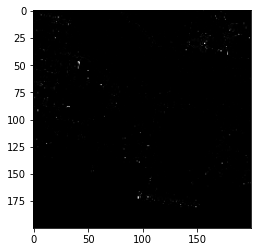

Multilook (Boxcar Filter)


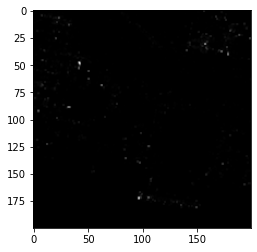

Conversion to Decibels


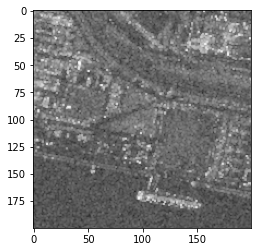

Orthorectification


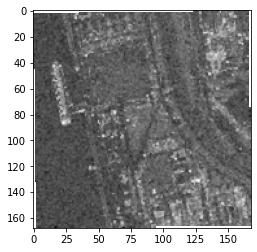

In [2]:
class SARClass(pipesegment.PipeSegment):
    def __init__(self):
        super().__init__()
        self.feeder = (
            image.LoadImage(os.path.join(datadir, 'sar_hh.tif'))
            * sar.CapellaScaleFactor()
            * sar.Intensity() * image.ShowImage(caption='Intensity')
            * sar.Multilook(2) * image.ShowImage(caption='Multilook (Boxcar Filter)')
            * sar.Decibels() * image.ShowImage(caption='Conversion to Decibels')
            * sar.Orthorectify(projection = 32631, row_res=3, col_res=3) * image.ShowImage(caption='Orthorectification')
            * image.SaveImage(os.path.join(datadir, 'output3a.tif'))
        )

sar_processing = SARClass()
sar_processing()

The API reference lists possible arguments for these various classes.  Things like the kernel size of the `Multilook` filter and how the `Decibel` class handles zeros can be adjusted through arguments.

Also in `preproc.sar` are classes for several polarimetric decompositions, including Freeman-Durden (for quad pol) and H-Alpha (for dual pol).  A Pauli decomposition is shown here:

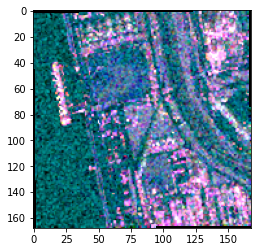

In [3]:
class SARDecomposition(pipesegment.PipeSegment):
    def __init__(self):
        super().__init__()
        loadlist = [image.LoadImage(os.path.join(datadir, file)) 
                    * sar.CapellaScaleFactor() for file in 
                    ['sar_hh.tif', 'sar_hv.tif', 'sar_vh.tif', 'sar_vv.tif']]
        stack = np.sum(loadlist) * image.MergeToStack()
        self.feeder = (
            stack
            * sar.DecompositionPauli(hh_band=0, vv_band=3, xx_band=1)
            * sar.Multilook(2)
            * sar.Decibels()
            * sar.Orthorectify(projection = 32631, row_res=3, col_res=3)
            * image.SaveImage(os.path.join(datadir, 'output3b.tif'))
            * image.ShowImage(bands=[1,2,0], vmin=-20, vmax=0)
        )

sar_decomposition = SARDecomposition()
sar_decomposition()

In the code above, note how `np.sum()` respects the special meaning of `+` for `PipeSegment` subclasses.

## Example 3 Follow-Up: Masking and Multimodal Datasets

Multimodal datasets contain multiple types of data covering the same area.  A common task when preparing such datasets is taking a mask from one data source and applying it to another.  

Suppose we have two equal-sized images covering the same area: a SAR image which is masked, and an optical image which isn't.  To apply the mask from the former to the latter:

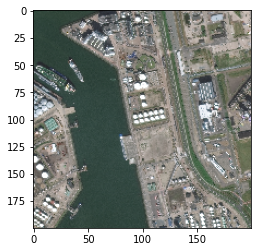

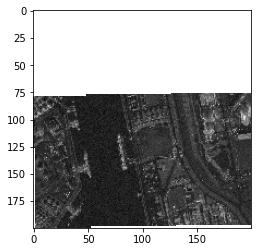

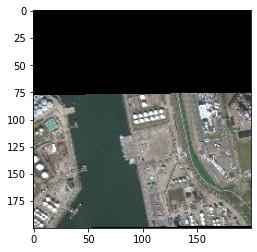

In [4]:
class TransferMask(pipesegment.PipeSegment):
    def __init__(self, masked_path, unmasked_path, output_path):
        super().__init__()
        load_masked = image.LoadImage(masked_path) * image.ShowImage(bands=[0])
        load_unmasked = image.LoadImage(unmasked_path) * image.ShowImage()
        get_mask = image.GetMask()
        set_mask = image.SetMask(0)
        save_output = image.SaveImage(output_path) * image.ShowImage()
        self.feeder = (load_unmasked + load_masked * get_mask) * set_mask * save_output

masked_path = os.path.join(datadir, 'sar_masked.tif')
unmasked_path = os.path.join(datadir, 'rgb_unmasked.tif')
output_path = os.path.join(datadir, 'output3c.tif')
transfer_mask = TransferMask(masked_path, unmasked_path, output_path)
transfer_mask()

The `SetMask` class expects two inputs: the first is the image to be masked, and the second is the mask to use.  An optional argument to `SetMask` allows for reversing the order of the arguments.  By default, `preproc` uses `NaN` (the `float` value that's "not a number") as the mask value, but this too can be modified with arguments to `GetMask` and `SetMask`.

For imagery labels and for data types beyond imagery, the `preproc.labels` module contains classes for working with vector labels and other data in GeoPandas.

## Epilogue

The classes in the preprocessing library can be used in different ways.  They can be used one-at-a-time within a traditional ("imperative") program, like this:

In [5]:
#Read in an image, and store it in the variable 'myimage'
myimage = image.LoadImage(os.path.join(datadir, 'ms1.tif'))()

#Now resize the image, and store the result in a different variable
mythumbnail = (myimage * image.Resize(50,50))()

(Note the empty parentheses at the end of each line -- these lines instantiate an object and call it immediately.)

But these classes are more powerful when they are attached to each other to build up more complicated workflows.  That can be done by defining a one-time-use object:

In [6]:
thumbnail_pipeline = image.LoadImage(os.path.join(datadir, 'ms1.tif')) \
    * image.Resize(50,50)
mythumbnail = thumbnail_pipeline()

Or by defining a reusable class:

In [7]:
class Thumbnail(pipesegment.PipeSegment):
    def __init__(self):
        super().__init__()
        load = image.LoadImage(os.path.join(datadir, 'ms1.tif'))
        size = image.Resize(50,50)
        self.feeder = load * size
thumbnail_pipeline = Thumbnail()
mythumbnail = thumbnail_pipeline()

By defining a workflow, the program takes care of details like figuring out the order in which to do the different calculations and remembering where each intermediate result is stored.  To see what the program is actually doing when the instance is called, replace `mythumbnail = thumbnail_pipeline()` with `mythumbnail = thumbnail_pipeline(verbose=1)`.  Or set the `verbose` argument to 2 or 3 for additional information.  This is useful for debugging.

Finally, this tutorial has focused on creating new capabilities by combining and using the library's existing classes.  For capabilities that can't be built out of the existing `preproc` classes, one can create a new class directly from the `PipeSegment` base class.  The new class should be given a `transform` method that takes some input, does a calculation, and returns some output.  The whole `preproc` source code is mostly classes of this type and is a ready source of examples.

For completeness, here's a short example.  This class takes a string as input and returns the string in all capital letters.

In [8]:
class Uppercase(pipesegment.PipeSegment):
    def transform(self, pin):
        return pin.upper()

(pipesegment.LoadSegment('Thanks for reading!') * Uppercase())()

'THANKS FOR READING!'